<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_10/b)_Fine_Tuning_a_Pretrained_Transformer_Backbone_(e_g_%2C_BERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Step 1: Install Required Libraries

In [1]:
#  Install required libraries
!pip install -q keras-nlp tensorflow_datasets


##  Step 2: Import Libraries

In [3]:
# Imports
import keras_nlp
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Step 3: Load Dataset (IMDB from TensorFlow Datasets)

In [4]:
# Load IMDB dataset (as raw text)
train_raw = tfds.load("imdb_reviews", split="train[:80%]", as_supervised=True)
val_raw = tfds.load("imdb_reviews", split="train[80%:]", as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2D8LAH_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2D8LAH_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2D8LAH_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Step 4: Preprocessing & Tokenization

In [5]:
# Load tokenizer
tokenizer = keras_nlp.models.BertTokenizer.from_preset("bert_base_en")

100%|██████████| 510/510 [00:00<00:00, 1.40MB/s]


100%|██████████| 548/548 [00:00<00:00, 1.12MB/s]


100%|██████████| 208k/208k [00:00<00:00, 646kB/s]


In [30]:
def tokenize_dataset(ds, tokenizer, max_len=128):
    input_ids, segment_ids, labels = [], [], []

    for text, label in tfds.as_numpy(ds):
        # Decode bytes to string
        text = text.decode("utf-8")

        # Tokenize and add special tokens
        tokens = tokenizer.tokenize(text)
        tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]

        # Convert tokens to IDs
        ids = tokenizer.convert_tokens_to_ids(tokens)

        # Pad or truncate to max_len
        pad_len = max_len - len(ids)
        if pad_len > 0:
            ids += [0] * pad_len
            segment = [0] * max_len
        else:
            ids = ids[:max_len]
            segment = [0] * max_len

        input_ids.append(ids)
        segment_ids.append(segment)
        labels.append(label)

    return np.array(input_ids), np.array(segment_ids), np.array(labels)


## Step 5: Load BERT Backbone and Build Model

In [31]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [32]:
train_input_ids, train_segment_ids, train_labels = tokenize_dataset(train_raw, tokenizer)
val_input_ids, val_segment_ids, val_labels = tokenize_dataset(val_raw, tokenizer)

## Step 6: Compile Model

In [35]:
from transformers import create_optimizer

# Define training steps
epochs = 3
batch_size = 32
train_data_size = len(train_input_ids)
steps_per_epoch = train_data_size // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

# Hugging Face optimizer and scheduler
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


## Step 7: Train the Model

In [36]:
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
625/625 [==============================] - 593s 873ms/step - loss: 0.3867 - accuracy: 0.8156 - val_loss: 0.2848 - val_accuracy: 0.8778
Epoch 2/3
625/625 [==============================] - 544s 870ms/step - loss: 0.2092 - accuracy: 0.9174 - val_loss: 0.3024 - val_accuracy: 0.8804
Epoch 3/3
625/625 [==============================] - 544s 870ms/step - loss: 0.0975 - accuracy: 0.9665 - val_loss: 0.3657 - val_accuracy: 0.8860


##  Step 8: Evaluate

In [37]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


157/157 [==============================] - 43s 275ms/step - loss: 0.3657 - accuracy: 0.8860
Validation Loss: 0.3657
Validation Accuracy: 0.8860


In [38]:
predictions = model.predict(val_ds)
predicted_labels = tf.argmax(predictions.logits, axis=1)

157/157 [==============================] - 46s 272ms/step


## Step 9: Compute and Plot the Confusion Matrix

157/157 [==============================] - 43s 276ms/step


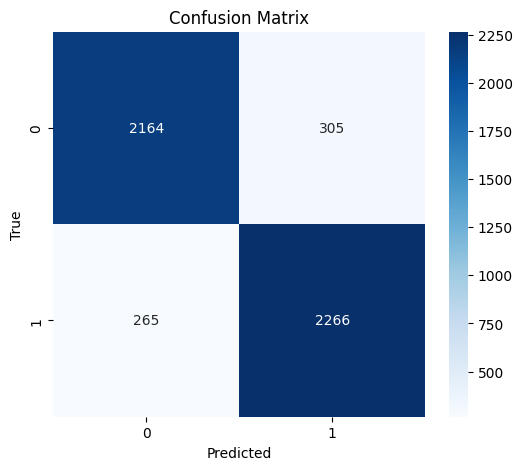

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get logits from the model
preds = model.predict(val_ds).logits

# Convert logits to predicted class indices
y_pred = np.argmax(preds, axis=1)

# Correctly extract true labels
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Step 10: Display Classification Report

In [43]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2469
           1       0.88      0.90      0.89      2531

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

